# Introduction (From June 2025)

In this notebook I compare the linear and FULL nonlinear mesh PDE's (no linearization via M) when both problems are supplied the 1D HR Hessian Mesh Density Function which is computed based on an exact ufl expression for $u.$ Ideally, these mesh PDE's should produce the same $x(\xi)$ meshes (because they are equivalent problems).

I also then use the results of the above test to fuel a manual MP-Iteration and the FieldSplit automatic MP-Iteration and compare the results. I HAVE NOW ADDED AN M SOLVE TO SMOOTH M, I HAVE FIXED ALPHA TILDE, AND I COMPUTE PHYSICAL SOLVES IN HER3

##### June 2025



# Introduction (August 2025)

There is alot going on in this notebook and I am having trouble parsing it later on. I think some of the key take-aways from this notebook are the individual pieces of code that can be pulled and used in other notebooks. Some of these include


- Bakhvalov Mesh Construction

- Analytic and numerical alpha_tilde solve at the beginning of the notebook but then I freeze alpha_tilde at that analytical value for the rest of the computation after.

- Chain ruled analytical Hessian calculation of firedrake ufl expression

- Linear HR Mesh solve based on the analytical Hessian

- Nonlinear HR Mesh solve based on the analytical Hessian

- Comparing Linear and Nonlinear Mesh Solves

- Doing a Physical Solve in HER3 here on the resulting mesh.

- Computing L2 and Energy norm errors of the Physical Solution

- Hessian Recovery Solve to smooth M.

- Manual MP-Iteration with alpha solves

- Comparing MP-Ieration to Fieldsplit code (without alpha solves)

- The meshes at the end of the whole notebook do not look right. I do not know why anymore. Maybe it was bad alpha?

- BAD RESULTS AT THE END

In [ ]:
# install firedrake

# hide output
%%capture

# try:
#     import firedrake
# except ImportError:
#     !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
#     import firedrake


try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [ ]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [ ]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d
from scipy.interpolate import interp1d
import sympy as sp
import scipy as sci

# Setup and Exact u

In [ ]:
# SETUP
#################################################

# Grid size and epsilon
N = 50
epsilon = Constant(0.01)


# solver parameters

lu_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}


newton_params = {
        'snes_type': 'newtonls',
        'snes_monitor': None,
        'ksp_type': 'preonly',
        'snes_linesearch_type': 'basic',
        'snes_linesearch_monitor': None,
        'snes_linesearch_damping': 0.5,
        # 'mat_type': 'nest'
        'pc_type' : 'lu'
}




# Set our parameters for the hessian mesh density
# d = 1
p = Constant(2)
q = Constant(2)
m = Constant(0)
exp_M = (2*q) / (1 + q*(2-m))
exp_rho = exp_M / 2
RHS = float(2.0)
alpha_hat = Constant(1)



# Initialize uniform mesh for xi
xi_mesh = UnitIntervalMesh(N)
xi_coord = SpatialCoordinate(xi_mesh)[0]


# Our function spaces
V = FunctionSpace(xi_mesh, "CG", 2)
V_alpha = FunctionSpace(xi_mesh, "R", 0)

# Set initial x(xi) to be uniform grid
x_old = Function(V)
x_old.interpolate(xi_coord)


# permute x_old to order coordinates
perm_x = np.argsort(x_old.dat.data[:])


# Set exact solution
top = (1 - exp(1 - 1/epsilon))*exp(-x_old/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x_old-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x_old)/(epsilon**2 - 1)
u_exact_xold = top/bottom - sub



# Create a B Mesh for Comparison

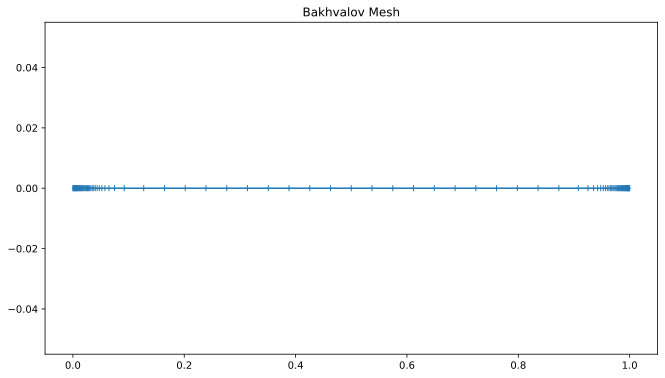

In [ ]:
# Form the 1D B mesh to compare

epsilon = 0.01
NB = 2*N
q = 0.4 #roughly 20 points in the layers
sigma = 2.5
b = 1
a = sigma/b
tau = q-a*epsilon
error = 1


while error>1e-14:

  g2 = a*epsilon*(0.5-tau)-(0.5+a*epsilon*np.log(1-tau/q))*(q-tau)
  g2_tau = 1 + a*epsilon*np.log(1-tau/q)
  tau_new =tau-g2/g2_tau
  error = abs(tau-tau_new)
  tau=tau_new


if tau>0:

  phi = -a*epsilon*np.log(1-tau/q)
  phi_tau = a*epsilon/(q-tau)
  x_uni = np.linspace(0, 1, NB+1)
  x_b = np.zeros(NB+1)

  for i in range(1,int(NB/2+1)):
    if x_uni[i]<tau:
      x_b[i] = -a*epsilon*np.log(1-x_uni[i]/q)
    else:
      x_b[i] = -a*epsilon*np.log(1-tau/q)+(x_uni[i]-tau)*phi_tau

  for i in range(int(NB/2+1),NB+1):
    x_b[i] = 1-x_b[NB-i]


else:

  x_b = np.linspace(0, 1, NB+1)


# Plot the result
plt.plot(x_b, [0 for i in range(NB+1)], marker = "|")
plt.title('Bakhvalov Mesh')
plt.show()




# Finding Exact(ish) Alpha

## Exact(ish) Alpha Tilda

In [ ]:
# FIND AN INITIAL ALPHA TILDA
#####################################################

# Find second derivative of u w.r.t x (symbolically)
xs, alpha_t = sp.symbols('xs, alpha_t')
eps = 0.01

# Define exact u symbolically
top = (1 - sp.exp(1 - 1/eps)) * sp.exp(-xs/eps) + (sp.exp(1) - sp.exp(-1/eps)) * sp.exp((xs - 1)/eps)
bottom = (eps**2 - 1) * (1 - sp.exp(-2/eps))
sub = sp.exp(xs) / (eps**2 - 1)
u_s = top / bottom - sub

# Take second derivative
du2_dx2 = sp.diff(u_s, xs, 2)

# Construct rho(x, alpha)
qs = 2
ms = 0
exp_rho_symp = (qs) / (1 + qs*(2-ms))
inside_bit = 1 + (1/alpha_t) * sp.Abs(du2_dx2)
rho = inside_bit ** (exp_rho_symp)

# Lambidfy rho
rho_func = sp.lambdify((xs, alpha_t), rho)


# Set up integral(rho) - 2 = 0
def alpha_tilda_problem(alpha_t):
  def integrand(xs_val):
    return rho_func(xs_val, alpha_t)
  int_val, _ = sci.integrate.quad(integrand, 0, 1)
  return int_val - 2


# Solve for alpha using fsolve
alpha_tilda = sci.optimize.fsolve(alpha_tilda_problem, 1)[0]
print('Our alpha_tilda is: ', alpha_tilda)

Our alpha_tilda is:  7.250865204319422


## Exact(ish) Alpha

In [ ]:
# NOW FIND ALPHA
###########################################


# a_hat = 1.0

L2_u = sp.sqrt(sp.integrate(u_s**2, (xs, 0, 1)))

L2_u_val = L2_u.evalf()


# Compute alpha = max( a_hat * L2_u , alpha_tilda )

alpha = max(L2_u_val, alpha_tilda)


print('Our alpha is: ', alpha)

Our alpha is:  7.250865204319422


# Compute the Hessian Mesh Density Function

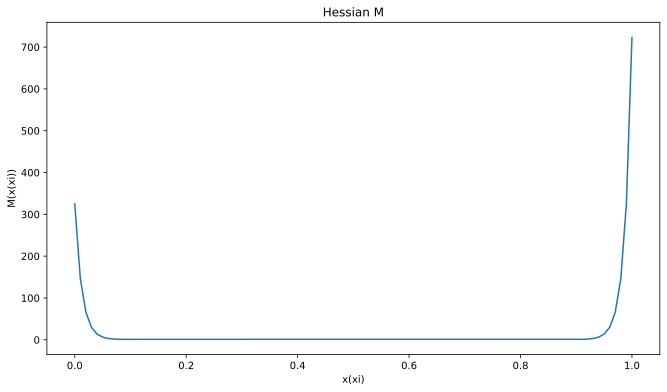

In [ ]:
# x_old jacobian
jacobx = x_old.dx(0)

# compute the derivatives of our u exact
u_pr_lin = u_exact_xold.dx(0)
u_prpr_lin = u_pr_lin.dx(0)
x_prpr_lin = jacobx.dx(0)
du_dx_lin = (1/jacobx) * u_pr_lin
du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)

# compute the Hessian M using computed alpha tilda

# Now compute M
inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
M_lin = inside_bit_lin ** (exp_M)
M_plot = Function(V).interpolate(inside_bit_lin ** (exp_M))

# Lets plot this hessian M
plt.plot(x_old.dat.data[perm_x], M_plot.dat.data[perm_x])
plt.xlabel("x(xi)")
plt.ylabel("M(x(xi))")
plt.title("Hessian M")
plt.show()
print()
print()

# Linear Mesh Solve

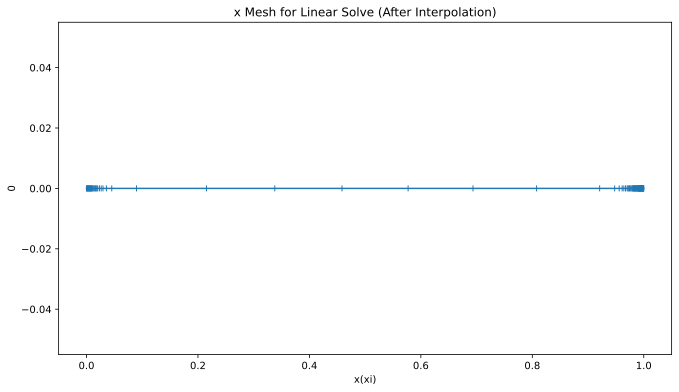

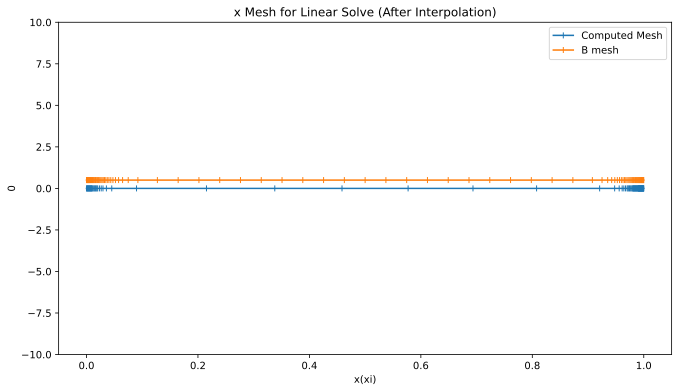

In [ ]:
# LINEAR Mesh Solve

# set solution and test function
new_xi = TrialFunction(V)
vm = TestFunction(V)

# jacobian
dxi_dx = new_xi.dx(0)

# v'
v_pr = (vm).dx(0)


# the problem
a = ( v_pr * (1/M_lin) * dxi_dx ) * dx
L = (Function(V) * vm ) * dx

# bc's
bc0 = DirichletBC(V, Constant(0), 1)
bc1 = DirichletBC(V, Constant(1), 2)
bcs = [bc0, bc1]

# solve
new_xi = Function(V)
solve( a == L, new_xi, bcs = bcs)


# Inverse Interpolation to get x
uni_array = x_old.dat.data[perm_x]
xi_array = new_xi.dat.data[perm_x]
x_xi = interp1d(xi_array, uni_array, kind='linear')
x_xi_array = x_xi(uni_array)


# Plot

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|")
plt.title('x Mesh for Linear Solve (After Interpolation)')
plt.xlabel("x(xi)")
plt.ylabel("0")
plt.show()
print()
print()

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|", label = "Computed Mesh")
plt.plot(x_b, [1/2 for i in range(len(x_b))], marker = "|", label = "B mesh")
plt.title('x Mesh for Linear Solve (After Interpolation)')
plt.xlabel("x(xi)")
plt.ylabel("0")
plt.ylim(-10, 10)
plt.legend()
plt.show()
print()
print()


# Nonlinear Mesh Solve Iteration



Mesh Iteration:  1
____________________________________________________________________________________________________


  0 SNES Function norm 2.569296950363e+01
  1 SNES Function norm 1.259085887291e+01
  2 SNES Function norm 6.236066135874e+00
  3 SNES Function norm 3.103615904022e+00
  4 SNES Function norm 1.548230714585e+00
  5 SNES Function norm 7.732171793891e-01
  6 SNES Function norm 3.863815024971e-01
  7 SNES Function norm 1.931332467135e-01
  8 SNES Function norm 9.655222335698e-02
  9 SNES Function norm 4.827267345192e-02
 10 SNES Function norm 2.413564399605e-02
 11 SNES Function norm 1.206777495868e-02
 12 SNES Function norm 6.033960178398e-03
 13 SNES Function norm 3.017051224608e-03
 14 SNES Function norm 1.508575271227e-03
 15 SNES Function norm 7.543186927765e-04
 16 SNES Function norm 3.771777881604e-04
 17 SNES Function norm 1.885995212668e-04
 18 SNES Function norm 9.430576268877e-05
 19 SNES Function norm 4.715622253172e-05




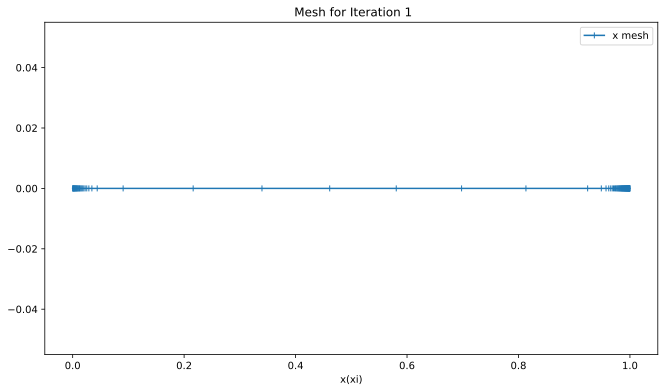





Mesh Iteration:  2
____________________________________________________________________________________________________


  0 SNES Function norm 4.715622253172e-05
  1 SNES Function norm 2.357995263584e-05


Quitting Mesh Iteration Because norm(x_new - x_old) =  1.1830977459516117e-09




In [ ]:
# NONlinear Mesh Solve

# damping for picard iteration:
w = 1

# Mesh Iteration tolerances
max_mesh_it = 100
mesh_tol = 1e-8
mesh_it = 0

# Set initial guess to be the result of the linear solve
x_old.dat.data[perm_x] = x_xi_array[:]
# x_old.interpolate(xi_coord)


# OUR PSEUDO MP-ITER. WE DO MESH SOLVE AND THEN UPDATE OUR EXACT U
################################################################

while mesh_it <= max_mesh_it:

  mesh_it += 1

  print()
  print()
  print('Mesh Iteration: ', mesh_it)
  print("_"*100)
  print()
  print()

  # MESH SOLVE
  ##############################################

  # set solution and test function
  new_x = Function(V)
  vm = TestFunction(V)

  # jacobian
  Jm = new_x.dx(0) #dx/dxi

  # Update u
  top = (1 - exp(1 - 1/epsilon))*exp(-new_x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((new_x-1)/epsilon)
  bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
  sub = exp(new_x)/(epsilon**2 - 1)
  u = top/bottom - sub


  # COMPUTE M (using mesh solve x)



  # compute the derivatives of our u
  u_pr = u.dx(0)
  u_prpr = u_pr.dx(0)
  x_prpr = Jm.dx(0)
  du_dx = (1/Jm) * u_pr
  du2_dx2 = ( u_prpr -  du_dx * x_prpr ) * (( 1/Jm )**2)

  # compute the Hessian M using computed alpha tilda
  inside_bit = 1 + (1/alpha) * abs(du2_dx2) # Corrected: use du2_dx2 instead of du2_dx2_lin
  M = inside_bit ** (exp_M)


  # v'
  v_pr_term = (vm).dx(0)

  # the lhs of the eqn
  Fm = (M * Jm * v_pr_term) * dx

  # bc's
  bc0 = DirichletBC(V, Constant(0), 1)
  bc1 = DirichletBC(V, Constant(1), 2)
  bcs = [bc0, bc1]


  # Set initial guess
  new_x.dat.data[:] = x_old.dat.data[:]

  # Solve
  solve( Fm == 0, new_x, bcs = bcs, solver_parameters = newton_params)


  # Check Mesh Tolerance
  norm_mesh_check = errornorm(new_x, x_old)

  if norm_mesh_check < mesh_tol :

    print()
    print()
    print("Quitting Mesh Iteration Because norm(x_new - x_old) = ", norm_mesh_check)
    print()
    print()
    # Save mesh solution in x_old
    x_old.dat.data[:] = new_x.dat.data[:]
    # Break our loop
    break


  # update our xold (damped picard)
  x_old.interpolate( (1-w) * x_old + w * new_x )

  # PLOT RESULTING MESH
  ################################################

  print()
  print()
  plt.plot(x_old.dat.data[perm_x], [0 for i in range(len(x_old.dat.data[:]))], marker = "|", label = "x mesh")
  plt.title(' Mesh for Iteration ' + str(mesh_it))
  plt.xlabel("x(xi)")
  plt.legend()
  plt.show()
  print()
  print()


if mesh_it > max_mesh_it:

  print("REACHED MAX MESH ITERATIONS!!")


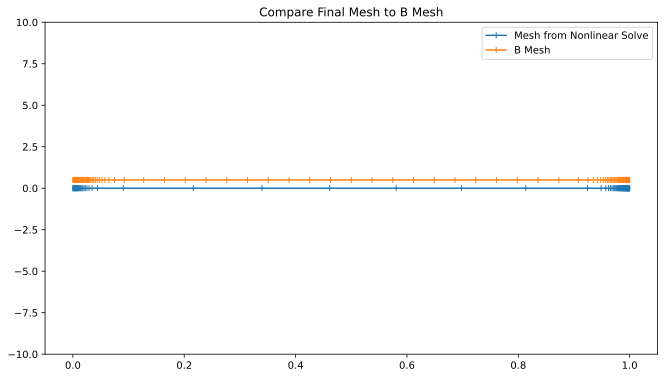

In [ ]:
# Plot result
plt.plot(x_old.dat.data[perm_x], [0 for i in range(len(x_old.dat.data[:]))], marker = "|", label = "Mesh from Nonlinear Solve")
plt.plot(x_b, [1/2 for i in range(len(x_b))], marker = "|", label = "B Mesh")
plt.title('Compare Final Mesh to B Mesh')
plt.ylim(-10, 10)
plt.legend()
plt.show()

# Compare the Results

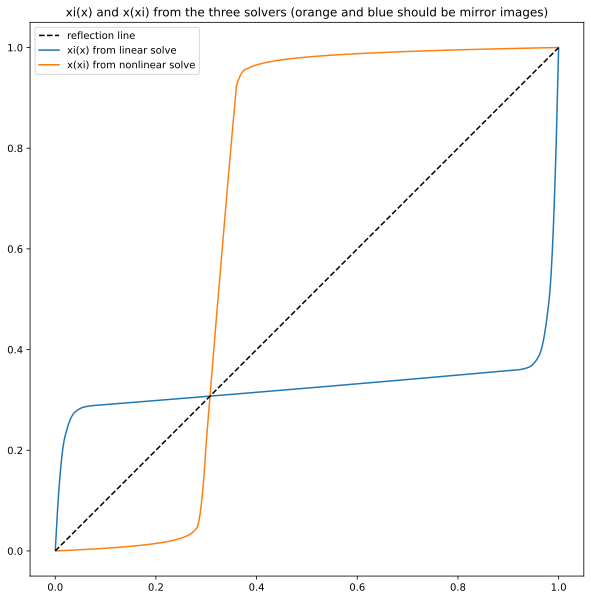

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (10, 10))

#dashed reflection line
plt.plot(np.linspace(0, 1, len(x_old.dat.data[:])), np.linspace(0, 1, len(x_old.dat.data[:])), linestyle = "--", color = "black", label = "reflection line")

# xi(x)
plot(new_xi, axes = axes, label = "xi(x) from linear solve")

# x(xi)
plot(x_old, axes = axes, label = "x(xi) from nonlinear solve")


axes.set_title("xi(x) and x(xi) from the three solvers (orange and blue should be mirror images)")
axes.set_aspect("equal")
plt.legend()
plt.show()
print()
print()

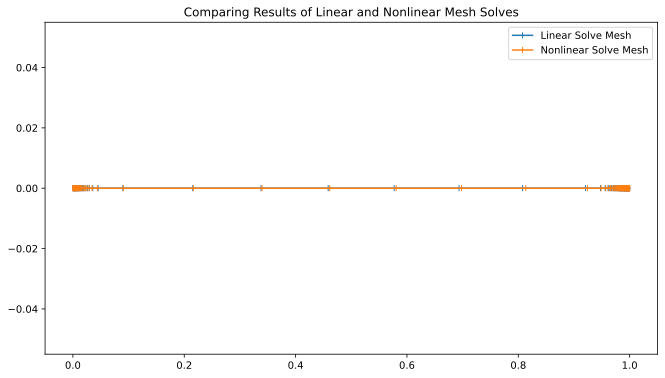

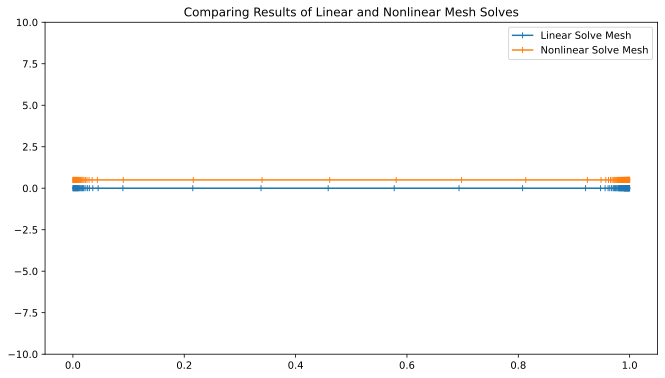

In [ ]:
# Compare the x(xi) meshes

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|", label = "Linear Solve Mesh")
plt.plot(x_old.dat.data[perm_x], [0 for i in range(len(x_old.dat.data[:]))], marker = "|", label = "Nonlinear Solve Mesh")
plt.title('Comparing Results of Linear and Nonlinear Mesh Solves')
plt.legend()
plt.show()
print()
print()

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|", label = "Linear Solve Mesh")
plt.plot(x_old.dat.data[perm_x], [1/2 for i in range(len(x_old.dat.data[:]))], marker = "|", label = "Nonlinear Solve Mesh")
plt.title('Comparing Results of Linear and Nonlinear Mesh Solves')
plt.ylim(-10, 10)
plt.legend()
plt.show()
print()
print()


# Now a Physical Solve - IN HER3 Now

  0 SNES Function norm 7.539035558640e-01
  1 SNES Function norm 6.049610852817e-06




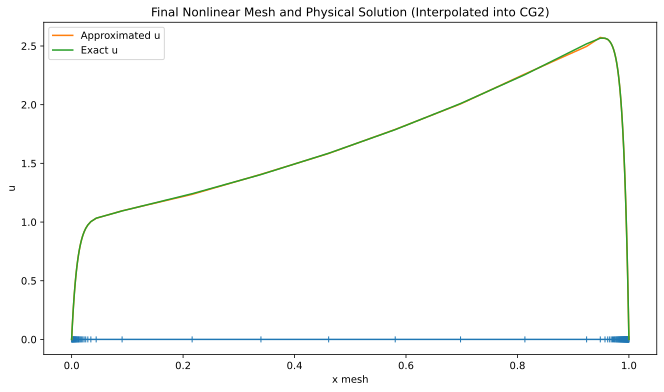

In [ ]:
# PHYSICAL SOLVE
##############################

# Define a HER3 space
V_high = FunctionSpace(xi_mesh, "HER", 3)

# Test and Trial Functions
u = TrialFunction(V_high)
v = TestFunction(V_high)

# Jacobian of x
Jx = x_old.dx(0) #dx/dxi


# Set the bilinear and linear forms of the weak form
u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
L = ( exp(x_old) ) * v * Jx * dx #transform dxi to dx


# Set the BC's
bcs = [DirichletBC(V_high, Constant(0), 1), DirichletBC(V_high, Constant(0), 2)]


# Solve
u = Function(V_high)
solve( a==L, u, bcs = bcs, solver_parameters = lu_params)

print()
print()


# Plot
plt.plot(x_old.dat.data[perm_x], np.zeros_like(x_old.dat.data[perm_x]), marker = "|")
plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(u).dat.data[perm_x], label = "Approximated u")
plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(u_exact_xold).dat.data[perm_x], label = "Exact u")
plt.title("Final Nonlinear Mesh and Physical Solution (Interpolated into CG2)")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()
print()
print()
print()

# Save x, u, alpha_tilda here for MP Iteration Guesses

In [ ]:
x_guess = Function(V)
x_guess.dat.data[:] = x_old.dat.data[:]

u_guess = Function(V_high)
u_guess.dat.data[:] = u.dat.data[:]

alpha_tilda_guess = alpha_tilda

# Errors

In [ ]:
# ERROR NORMS
###################################


# Compute L^2 and H^1 errors

# Jacobian of x
Jx = x_old.dx(0)


# L^2 error
error_val = (u - u_exact_xold)
L2_error = norm(error_val * (sqrt(abs(Jx))))
print("L2 error is", L2_error)
print()




# H1 error
# (\epsilon^2 || u' ||_0^2 + || u ||_0^2 ) ^{1/2}
u_approx_pr = (1/Jx) * u.dx(0)
u_exact_pr = (1/Jx) * u_exact_xold.dx(0)
u_pr_error = (u_approx_pr - u_exact_pr)
L2_pr = norm(u_pr_error * (sqrt(abs(Jx))))
H1_error =  float(sqrt( (epsilon**2) * (L2_pr**2) + (L2_error**2) ))
print("H1 error is", H1_error)

L2 error is 0.003694083317867576

H1 error is 0.004928494516312252


# Manual MP-Iteration

## ITER 1

### Solve for Smoothed Hessian M

  0 SNES Function norm 1.635233482417e+00
  1 SNES Function norm 5.291186457731e-15



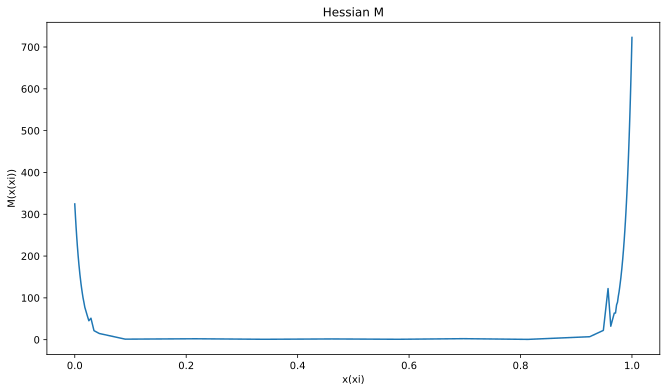

In [ ]:
# solver parameters

lu_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}


# Define test and trial function
M_test = TestFunction(V)
M = Function(V)


# x_old jacobian
jacobx = x_old.dx(0)
# compute the derivatives of our computed u in HER3
u_pr_lin = u.dx(0)
u_prpr_lin = u_pr_lin.dx(0)
x_prpr_lin = jacobx.dx(0)
du_dx_lin = (1/jacobx) * u_pr_lin
du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)
# compute the Hessian M using computed alpha tilda
# Compute alpha using alpha tilda
alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
alpha = conditional( gt(alpha_term1, alpha_tilda) , alpha_term1, alpha_tilda)
# Now compute M
inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
M_h = inside_bit_lin ** (exp_M)


# The weak form
a_M = inner(M*jacobx, M_test)*dx
L_M = inner(M_h*jacobx, M_test)*dx


# Solve
M.interpolate(M_h)
solve((a_M - L_M) == 0, M, solver_parameters = lu_params)

# Print result
print()
plt.plot(x_old.dat.data[perm_x], M.dat.data[perm_x])
plt.xlabel("x(xi)")
plt.ylabel("M(x(xi))")
plt.title("Hessian M")
plt.show()
print()
print()

### Mesh Solve

In [ ]:
# MESH SOLVE
#############################################




# SETUP


mesh_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'richardson',
    # 'ksp_richardson_scale': 0.5,
    'pc_type': 'lu',
}





# MESH PROBLEM

print('norm(xold) = ', norm(x_old))
print()



# set solution and test function
new_x = Function(V).interpolate(x_old)
vm = TestFunction(V)

# jacobian
Jm = new_x.dx(0) #dx/dxi

# v'
v_pr_term = (vm).dx(0)

# the lhs of the eqn
am = (M * Jm * v_pr_term) * dx


# bc's
bc0 = DirichletBC(V, Constant(0), 1)
bc1 = DirichletBC(V, Constant(1), 2)
bcs = [bc0, bc1]


# Solve
solve( am == 0, new_x, bcs = bcs, solver_parameters = mesh_params)


print()
print('norm(x_new)) = ', norm(new_x))
print()
print()

norm(xold) =  0.8044565964344133

  0 SNES Function norm 6.212221411247e+01
  1 SNES Function norm 7.978132476945e-11

norm(x_new)) =  0.8067985078720211




### Comparing Meshes

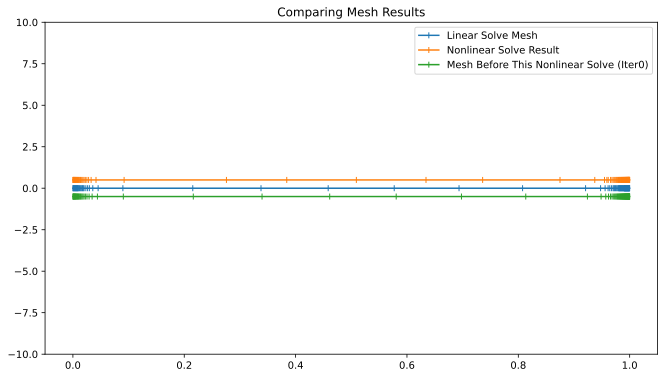

In [ ]:
# Compare to the Linear Solve Mesh

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|", label = "Linear Solve Mesh")
plt.plot(new_x.dat.data[perm_x], [1/2 for i in range(len(new_x.dat.data[:]))], marker = "|", label = "Nonlinear Solve Result")
plt.plot(x_old.dat.data[perm_x], [-1/2 for i in range(len(x_old.dat.data[:]))], marker = "|", label = "Mesh Before This Nonlinear Solve (Iter0)")
plt.title('Comparing Mesh Results')
plt.ylim(-10, 10)
plt.legend()
plt.show()
print()
print()

### Physical Solve

norm(u) before =  1.4581902788199153

  0 SNES Function norm 7.754031219459e-01
  1 SNES Function norm 1.358203199599e-04


norm(u) after =  1.4698278347420848



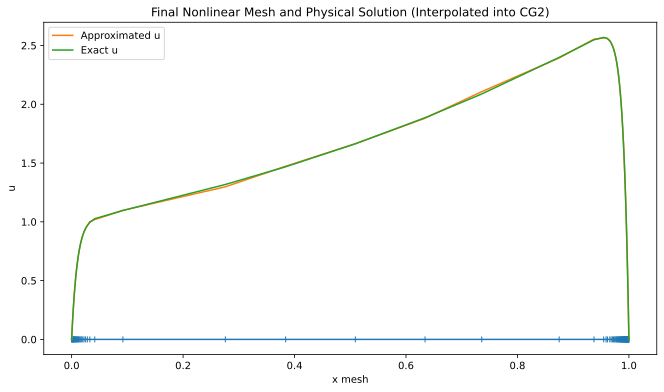

In [ ]:
# PHYSICAL SOLVE
##############################

print('norm(u) before = ', norm(u))
print()


# Update x_old as new_x
x_old.dat.data[:] = new_x.dat.data[:]

# Test and Trial Functions
u = TrialFunction(V_high)
v = TestFunction(V_high)

# Jacobian of x
Jx = x_old.dx(0) #dx/dxi


# Set the bilinear and linear forms of the weak form
u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
L = ( exp(x_old) ) * v * Jx * dx #transform dxi to dx


# Set the BC's
bcs = [DirichletBC(V_high, Constant(0), 1), DirichletBC(V_high, Constant(0), 2)]


# Solve
u = Function(V_high)
solve( a==L, u, bcs = bcs, solver_parameters = lu_params)

print()
print()
print('norm(u) after = ', norm(u))
print()




# Plot
plt.plot(x_old.dat.data[perm_x], np.zeros_like(x_old.dat.data[perm_x]), marker = "|")
plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(u).dat.data[perm_x], label = "Approximated u")
plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(u_exact_xold).dat.data[perm_x], label = "Exact u")
plt.title("Final Nonlinear Mesh and Physical Solution (Interpolated into CG2)")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()
print()
print()
print()




## ITER 2

### Solve for Smoothed Hessian M

  0 SNES Function norm 1.635233482417e+00
  1 SNES Function norm 5.291186457731e-15



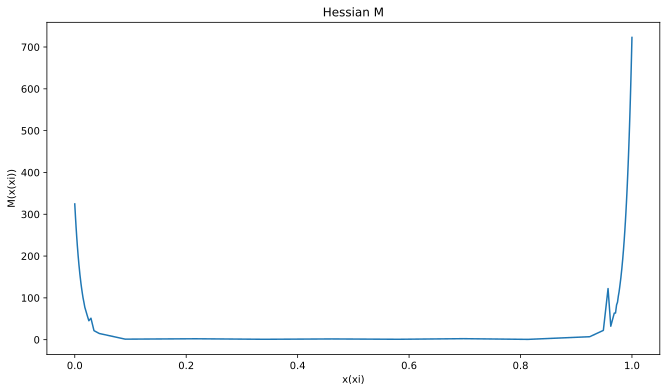

In [ ]:
# Define test and trial function
M_test = TestFunction(V)
M = Function(V)


# x_old jacobian
jacobx = x_old.dx(0)
# compute the derivatives of our computed u in HER3
u_pr_lin = u.dx(0)
u_prpr_lin = u_pr_lin.dx(0)
x_prpr_lin = jacobx.dx(0)
du_dx_lin = (1/jacobx) * u_pr_lin
du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)
# compute the Hessian M using computed alpha tilda
# Compute alpha using alpha tilda
alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
alpha = conditional( gt(alpha_term1, alpha_tilda) , alpha_term1, alpha_tilda)
# Now compute M
inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
M_h = inside_bit_lin ** (exp_M)


# The weak form
a_M = inner(M*jacobx, M_test)*dx
L_M = inner(M_h*jacobx, M_test)*dx


# Solve
M.interpolate(M_h)
solve((a_M - L_M) == 0, M, solver_parameters = lu_params)

# Print result
print()
plt.plot(x_old.dat.data[perm_x], M.dat.data[perm_x])
plt.xlabel("x(xi)")
plt.ylabel("M(x(xi))")
plt.title("Hessian M")
plt.show()
print()
print()

### Mesh Solve

In [ ]:
# MESH SOLVE
#############################################


# MESH PROBLEM

print('norm(xold) = ', norm(x_old))
print()

# Save this mesh for later
mesh_iter1 = Function(V)
mesh_iter1.dat.data[:] = x_old.dat.data[:]


# set solution and test function
new_x = Function(V).interpolate(x_old)
vm = TestFunction(V)

# jacobian
Jm = new_x.dx(0) #dx/dxi

# v'
v_pr_term = (vm).dx(0)

# the lhs of the eqn
am = (M * Jm * v_pr_term) * dx


# bc's
bc0 = DirichletBC(V, Constant(0), 1)
bc1 = DirichletBC(V, Constant(1), 2)
bcs = [bc0, bc1]


# Solve
solve( am == 0, new_x, bcs = bcs, solver_parameters = mesh_params)


print()
print('norm(x_new)) = ', norm(new_x))
print()
print()

norm(xold) =  0.8067985078720211

  0 SNES Function norm 6.543031273740e+01
  1 SNES Function norm 6.253226035118e-11

norm(x_new)) =  0.7977958635672036




### Comparing Meshes

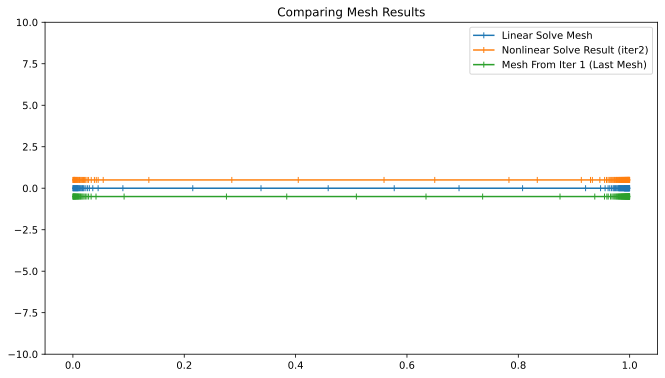

In [ ]:
# Compare to the Linear Solve Mesh AND the Last Mesh

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|", label = "Linear Solve Mesh")
plt.plot(new_x.dat.data[perm_x], [1/2 for i in range(len(new_x.dat.data[:]))], marker = "|", label = "Nonlinear Solve Result (iter2)")
plt.plot(x_old.dat.data[perm_x], [-1/2 for i in range(len(x_old.dat.data[:]))], marker = "|", label = "Mesh From Iter 1 (Last Mesh)")
plt.title('Comparing Mesh Results')
plt.ylim(-10, 10)
plt.legend()
plt.show()
print()
print()

### Physical Solve

norm(u) before =  1.4698278347420848

  0 SNES Function norm 7.433571511148e-01
  1 SNES Function norm 1.293177021588e-04


norm(u) after =  1.6043074361351275



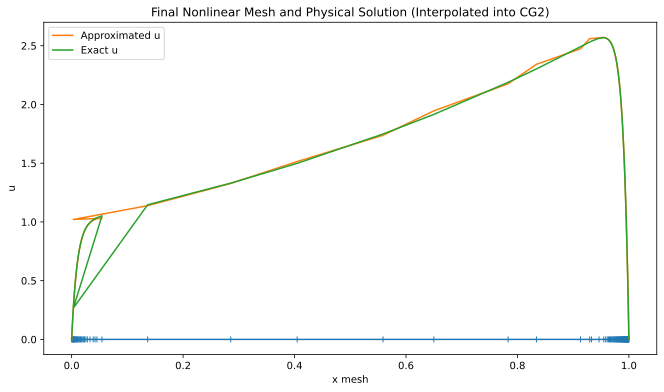

In [ ]:
# PHYSICAL SOLVE
##############################

print('norm(u) before = ', norm(u))
print()


# Update x_old as new_x
x_old.dat.data[:] = new_x.dat.data[:]

# Test and Trial Functions
u = TrialFunction(V_high)
v = TestFunction(V_high)

# Jacobian of x
Jx = x_old.dx(0) #dx/dxi


# Set the bilinear and linear forms of the weak form
u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
L = ( exp(x_old) ) * v * Jx * dx #transform dxi to dx


# Set the BC's
bcs = [DirichletBC(V_high, Constant(0), 1), DirichletBC(V_high, Constant(0), 2)]


# Solve
u = Function(V_high)
solve( a==L, u, bcs = bcs, solver_parameters = lu_params)

print()
print()
print('norm(u) after = ', norm(u))
print()




# Plot
plt.plot(x_old.dat.data[perm_x], np.zeros_like(x_old.dat.data[perm_x]), marker = "|")
plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(u).dat.data[perm_x], label = "Approximated u")
plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(u_exact_xold).dat.data[perm_x], label = "Exact u")
plt.title("Final Nonlinear Mesh and Physical Solution (Interpolated into CG2)")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()
print()
print()
print()




## ITER 3

### Solve for Smoothed Hessian M

  0 SNES Function norm 2.122657034089e+00
  1 SNES Function norm 1.768080910104e-13



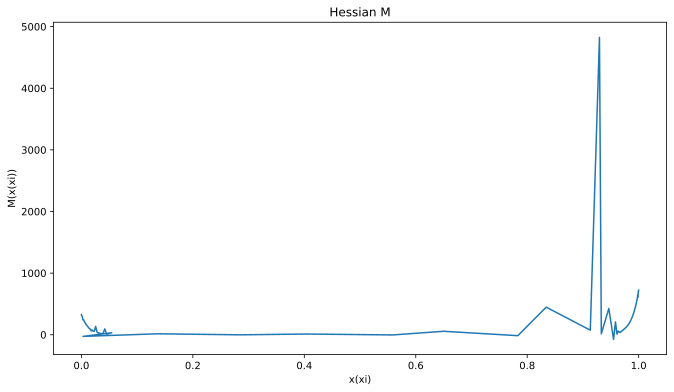

In [ ]:
# Define test and trial function
M_test = TestFunction(V)
M = Function(V)


# x_old jacobian
jacobx = x_old.dx(0)
# compute the derivatives of our computed u in HER3
u_pr_lin = u.dx(0)
u_prpr_lin = u_pr_lin.dx(0)
x_prpr_lin = jacobx.dx(0)
du_dx_lin = (1/jacobx) * u_pr_lin
du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)
# compute the Hessian M using computed alpha tilda
# Compute alpha using alpha tilda
alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
alpha = conditional( gt(alpha_term1, alpha_tilda) , alpha_term1, alpha_tilda)
# Now compute M
inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
M_h = inside_bit_lin ** (exp_M)


# The weak form
a_M = inner(M*jacobx, M_test)*dx
L_M = inner(M_h*jacobx, M_test)*dx


# Solve
M.interpolate(M_h)
solve((a_M - L_M) == 0, M, solver_parameters = lu_params)

# Print result
print()
plt.plot(x_old.dat.data[perm_x], M.dat.data[perm_x])
plt.xlabel("x(xi)")
plt.ylabel("M(x(xi))")
plt.title("Hessian M")
plt.show()
print()
print()

### Mesh Solve

In [ ]:
# MESH SOLVE
#############################################


# MESH PROBLEM

print('norm(xold) = ', norm(x_old))
print()

# Save result of last iteration for later
mesh_iter2 = Function(V)
mesh_iter2.dat.data[:] = x_old.dat.data[:]

# set solution and test function
new_x = Function(V).interpolate(x_old)
vm = TestFunction(V)

# jacobian
Jm = new_x.dx(0) #dx/dxi

# v'
v_pr_term = (vm).dx(0)

# the lhs of the eqn
am = (M * Jm * v_pr_term) * dx


# bc's
bc0 = DirichletBC(V, Constant(0), 1)
bc1 = DirichletBC(V, Constant(1), 2)
bcs = [bc0, bc1]


# Solve
solve( am == 0, new_x, bcs = bcs, solver_parameters = mesh_params)


print()
print('norm(x_new)) = ', norm(new_x))
print()
print()


# Save this mesh for later comparison
x_noMP = Function(V)
x_noMP.dat.data[:] = new_x.dat.data[:]

norm(xold) =  0.7977958635672036

  0 SNES Function norm 1.515069725086e+03
  1 SNES Function norm 6.359192440273e-11

norm(x_new)) =  0.8103311093460694




### Comparing Meshes

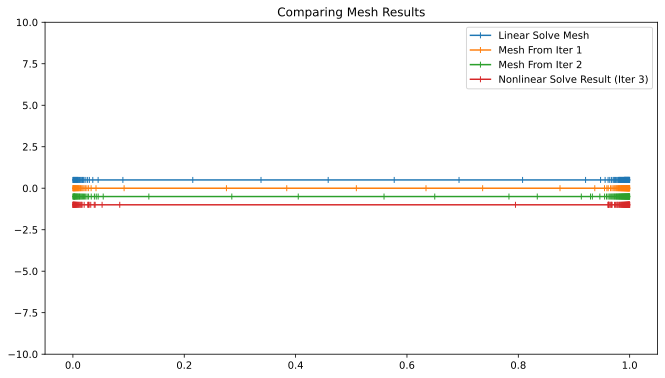

In [ ]:
# Compare to the Linear Solve Mesh AND the Last Mesh

plt.plot(x_xi_array, [1/2 for i in range(len(x_xi_array))], marker = "|", label = "Linear Solve Mesh")
plt.plot(mesh_iter1.dat.data[perm_x], [0 for i in range(len(mesh_iter1.dat.data[:]))], marker = "|", label = "Mesh From Iter 1")
plt.plot(mesh_iter2.dat.data[perm_x], [-1/2 for i in range(len(mesh_iter2.dat.data[:]))], marker = "|", label = "Mesh From Iter 2")
plt.plot(new_x.dat.data[perm_x], [-1 for i in range(len(new_x.dat.data[:]))], marker = "|", label = "Nonlinear Solve Result (Iter 3)")
plt.title('Comparing Mesh Results')
plt.ylim(-10, 10)
plt.legend()
plt.show()
print()
print()

### Physical Solve

norm(u) before =  1.6043074361351275

  0 SNES Function norm 1.211312173862e+00
  1 SNES Function norm 1.209220809945e-02


norm(u) after =  1.323484071630138



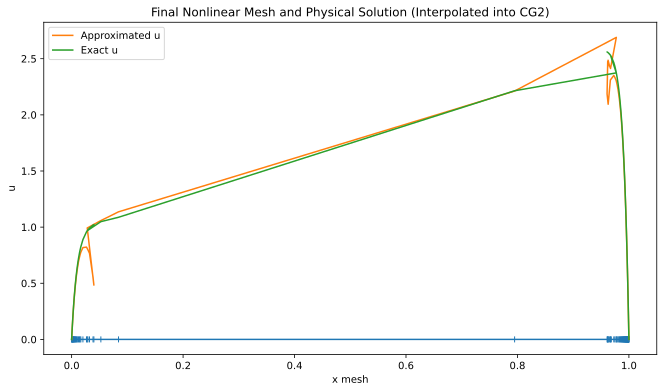

In [ ]:
# PHYSICAL SOLVE
##############################

print('norm(u) before = ', norm(u))
print()


# Update x_old as new_x
x_old.dat.data[:] = new_x.dat.data[:]

# Test and Trial Functions
u = TrialFunction(V_high)
v = TestFunction(V_high)

# Jacobian of x
Jx = x_old.dx(0) #dx/dxi


# Set the bilinear and linear forms of the weak form
u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
L = ( exp(x_old) ) * v * Jx * dx #transform dxi to dx


# Set the BC's
bcs = [DirichletBC(V_high, Constant(0), 1), DirichletBC(V_high, Constant(0), 2)]


# Solve
u = Function(V_high)
solve( a==L, u, bcs = bcs, solver_parameters = lu_params)

print()
print()
print('norm(u) after = ', norm(u))
print()




# Plot
plt.plot(x_old.dat.data[perm_x], np.zeros_like(x_old.dat.data[perm_x]), marker = "|")
plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(u).dat.data[perm_x], label = "Approximated u")
plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(u_exact_xold).dat.data[perm_x], label = "Exact u")
plt.title("Final Nonlinear Mesh and Physical Solution (Interpolated into CG2)")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()
print()
print()
print()




#  MP-Iteration Via FieldSplit (3 Iterations)

## Solvers

In [ ]:
from firedrake.preconditioners.base import SNESBase
from firedrake.petsc import PETSc
from firedrake.dmhooks import get_appctx, get_function_space
from firedrake.function import Function



__all__ = ("FieldsplitSNES",)


class FieldsplitSNES(SNESBase):
    prefix = "fieldsplit_"

    # TODO:
    #   - Allow setting field grouping/ordering like fieldsplit

    @PETSc.Log.EventDecorator()
    def initialize(self, snes):
        from firedrake.variational_solver import NonlinearVariationalSolver  # ImportError if we do this at file level
        ctx = get_appctx(snes.dm)
        W = get_function_space(snes.dm)
        self.sol = ctx._problem.u_restrict

        # buffer to save solution to outer problem during solve
        self.sol_outer = Function(self.sol.function_space())

        # buffers for shuffling solutions during solve
        self.sol_current = Function(self.sol.function_space())
        self.sol_new = Function(self.sol.function_space())

        # options for setting up the fieldsplit
        snes_prefix = snes.getOptionsPrefix() + 'snes_' + self.prefix
        # options for each field
        sub_prefix = snes.getOptionsPrefix() + self.prefix

        snes_options = PETSc.Options(snes_prefix)
        self.fieldsplit_type = snes_options.getString('type', 'additive')
        if self.fieldsplit_type not in ('additive', 'multiplicative'):
            raise ValueError(
                'FieldsplitSNES option snes_fieldsplit_type must be'
                ' "additive" or "multiplicative"')

        split_ctxs = ctx.split([(i,) for i in range(len(W))])

        self.solvers = tuple(
            NonlinearVariationalSolver(
                ctx._problem, appctx=ctx.appctx,
                options_prefix=sub_prefix+str(i))
            for i, ctx in enumerate(split_ctxs)
        )

    def update(self, snes):
        pass

    @PETSc.Log.EventDecorator()
    def step(self, snes, x, f, y):
        # store current value of outer solution
        self.sol_outer.assign(self.sol)

        # the full form in ctx now has the most up to date solution
        with self.sol_current.dat.vec_wo as vec:
            x.copy(vec)
        self.sol.assign(self.sol_current)

        # The current snes solution x is held in sol_current, and we
        # will place the new solution in sol_new.
        # The solvers evaluate forms containing sol, so for each
        # splitting type sol needs to hold:
        #   - additive: all fields need to hold sol_current values
        #   - multiplicative: fields need to hold sol_current before
        #       they are are solved for, and keep the updated sol_new
        #       values afterwards.


        solver_count = 0
        solver_list = ["M update", "mesh solve", "physical solve", "mesh update", "alpha solve"]
        print()
        print()
        print()
        print()
        print("MP ITERATION")
        print('_'*50)
        print()





        for solver, u, ucurr, unew in zip(self.solvers,
                                          self.sol.subfunctions,
                                          self.sol_current.subfunctions,
                                          self.sol_new.subfunctions):



            print(solver_list[solver_count])
            print('_'*50)
            print()


            if solver_count == 0:

              x_perm_insolver = np.argsort(self.sol.subfunctions[1].dat.data[:])

              plt.plot(self.sol.subfunctions[1].dat.data[x_perm_insolver], self.sol.subfunctions[0].dat.data[x_perm_insolver])
              plt.plot(self.sol.subfunctions[1].dat.data[x_perm_insolver], [0 for i in range(len(self.sol.subfunctions[1].dat.data[x_perm_insolver]))], marker = "|")
              plt.title("M before solve")
              plt.show()
              print()
              print()


            print('norm(u) before solve = ', norm(u))
            print()


            # print('The solver problem is',  solver._problem.F)
            # print()

            # print('The solver is solving for', solver._problem.u)
            # print()



            solver.solve()
            unew.assign(u)
            if self.fieldsplit_type == 'additive':
                u.assign(ucurr)



            print()
            print('norm(u) after solve = ', norm(u))
            print()


            if solver_count == 0:

              plt.plot(self.sol.subfunctions[1].dat.data[x_perm_insolver], self.sol.subfunctions[0].dat.data[x_perm_insolver])
              plt.plot(self.sol.subfunctions[1].dat.data[x_perm_insolver], [0 for i in range(len(self.sol.subfunctions[1].dat.data[x_perm_insolver]))], marker = "|")
              plt.title("M after solve")
              plt.show()
              print()
              print()


            solver_count += 1


        with self.sol_new.dat.vec_ro as vec:
            vec.copy(y)
            y.aypx(-1, x)

        # restore outer solution
        self.sol.assign(self.sol_outer)

## Setup

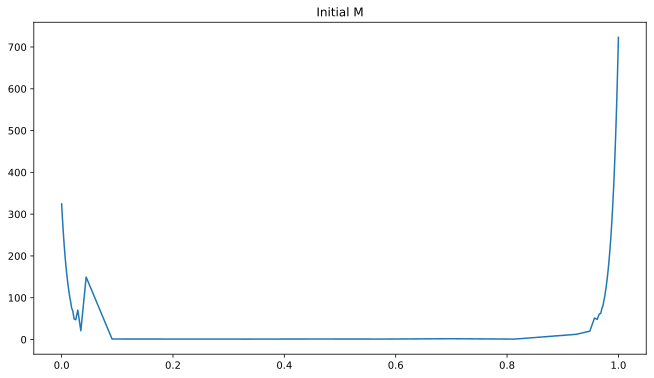

In [ ]:
# SET UP FOR MP ITERATION
##############################################


# OUr function space and solutions
W = V * V * V_high * V
mxux = Function(W)
myvy = TestFunction(W)


# An initial guess for M
# Based off of the nonlinear mesh iteration result and the HER3 physical solution
# Not from the manual MP Iteration I did.

jacobx = x_guess.dx(0)
u_pr_lin = u_guess.dx(0)
u_prpr_lin = u_pr_lin.dx(0)
x_prpr_lin = jacobx.dx(0)
du_dx_lin = (1/jacobx) * u_pr_lin
du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)
alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
alpha = conditional( gt(alpha_term1, alpha_tilda_guess) , alpha_term1, alpha_tilda_guess)
inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
M_guess = inside_bit_lin ** (exp_M)



# set our initial guesses
mxux.sub(0).interpolate(M_guess)
mxux.sub(1).interpolate(x_guess) # from full nonlinear mesh iter
mxux.sub(2).project(u_guess) # from first HER3 physical solve
mxux.sub(3).interpolate(x_guess)
alpha_tilda = float(alpha_tilda_guess) # our exact alpha tilda


plt.plot(mxux.sub(1).dat.data[:], mxux.sub(0).dat.data[:])
plt.title("Initial M")
plt.show()
print()
print()



## Test





MP ITERATION
__________________________________________________

M update
__________________________________________________



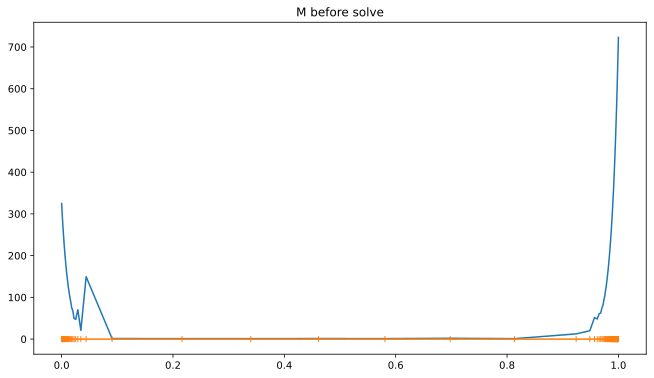



norm(u) before solve =  349.53958301707564

  0 SNES Function norm 1.635233482417e+00
  1 SNES Function norm 4.557263902935e-15

norm(u) after solve =  349.41588820007064



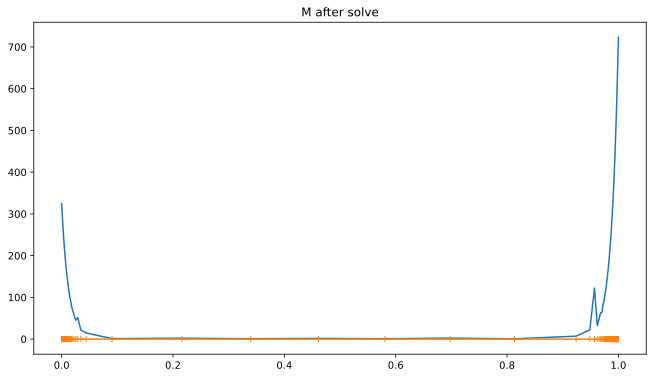



mesh solve
__________________________________________________

norm(u) before solve =  0.8044565964344133

  0 SNES Function norm 6.212221411247e+01
  1 SNES Function norm 7.956837408478e-11

norm(u) after solve =  0.8067985078720212

physical solve
__________________________________________________

norm(u) before solve =  1.4581902788199153

  0 SNES Function norm 3.585328967856e-02
  1 SNES Function norm 9.200559072402e-05

norm(u) after solve =  1.4689597673443926

mesh update
__________________________________________________

norm(u) before solve =  0.8044565964344133

  0 SNES Function norm 1.317662510053e-03
  1 SNES Function norm 1.042660271467e-18

norm(u) after solve =  0.8067985078720212

  0 SNES Function norm 4.436343291825e+02
  1 SNES Function norm 2.204940406261e+02




MP ITERATION
__________________________________________________

M update
__________________________________________________



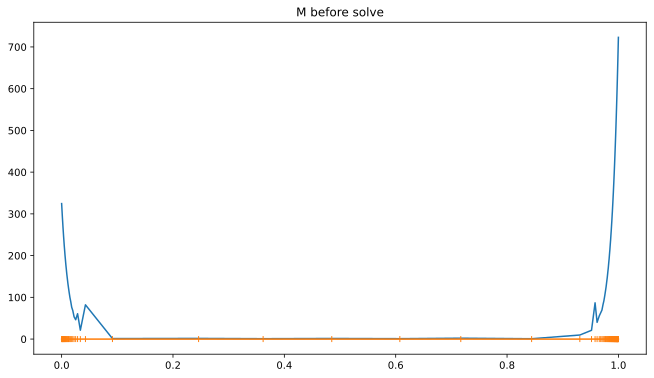



norm(u) before solve =  349.43259919695055

  0 SNES Function norm 2.701538327691e+01
  1 SNES Function norm 5.022382993457e-13

norm(u) after solve =  1292.0167391714058



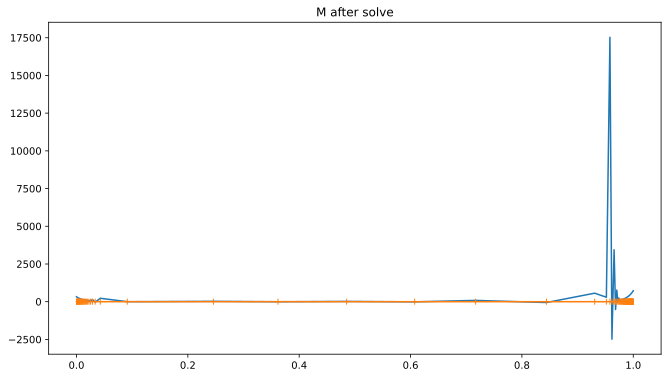



mesh solve
__________________________________________________

norm(u) before solve =  0.8056036736018497

  0 SNES Function norm 7.560953110562e+03
  1 SNES Function norm 3.194938414314e-09

norm(u) after solve =  2.4240372621144513

physical solve
__________________________________________________

norm(u) before solve =  1.4635344883272872

  0 SNES Function norm 6.084597490003e+01
  1 SNES Function norm 2.076669035313e-02

norm(u) after solve =  27.573272227322096

mesh update
__________________________________________________

norm(u) before solve =  0.8056036736018497

  0 SNES Function norm 1.924705658896e-01
  1 SNES Function norm 3.298639362925e-17

norm(u) after solve =  2.4240372621144513

  2 SNES Function norm 2.534825142454e+03




MP ITERATION
__________________________________________________

M update
__________________________________________________



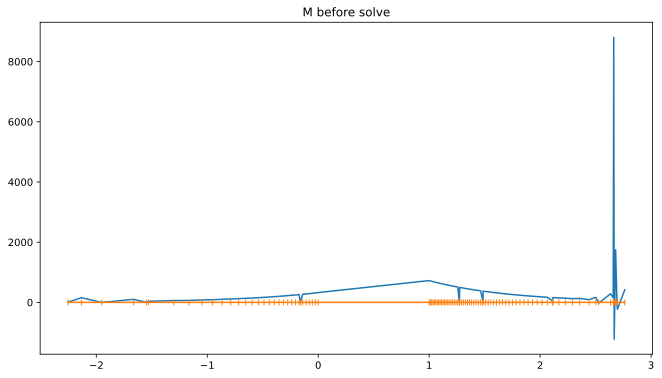



norm(u) before solve =  716.1871862093944

  0 SNES Function norm 1.462755323412e+02
  1 SNES Function norm 4.414835994344e-11

norm(u) after solve =  22077.925816154064



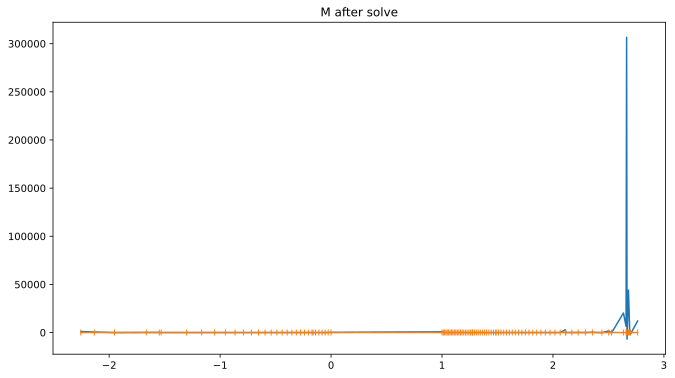



mesh solve
__________________________________________________

norm(u) before solve =  1.5486049376934945

  0 SNES Function norm 3.197500711751e+05
  1 SNES Function norm 3.745536601749e-08

norm(u) after solve =  0.6006042074334373

physical solve
__________________________________________________

norm(u) before solve =  14.367998193571808

  0 SNES Function norm 6.712043626984e+01
  1 SNES Function norm 2.135811612913e+02

norm(u) after solve =  7.360034019700747

mesh update
__________________________________________________

norm(u) before solve =  1.5486049376934945

  0 SNES Function norm 1.283938952947e-01
  1 SNES Function norm 2.278696233417e-17

norm(u) after solve =  0.6006042074334373

  3 SNES Function norm 8.018410254240e+04


Solver failed because of the following message:
Nonlinear solve failed to converge after 3 nonlinear iterations.
Reason:
   DIVERGED_MAX_IT



In [ ]:
# MP ITERATION
################################################


# Retrieve our functions
M, x,u, x_old = split(mxux)
M_test, y,v, y_old = split(myvy)



# x_old jacobian
jacobx = x_old.dx(0) #dx/dxi

# compute the derivatives of our u
u_pr_lin = u.dx(0)
u_prpr_lin = u_pr_lin.dx(0)
x_prpr_lin = jacobx.dx(0)
du_dx_lin = (1/jacobx) * u_pr_lin
du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)


# compute the Hessian M using computed alpha tilda

# Compute alpha using alpha tilda
alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
alpha = conditional( gt(alpha_term1, alpha_tilda) , alpha_term1, alpha_tilda)
# Compute Mh
inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
M_h = inside_bit_lin ** (exp_M)
# Weak form for projected M
a_M = inner(M*jacobx, M_test) * dx
L_M = inner(M_h*jacobx, M_test) * dx



# jacobian based on current x
Jm = x.dx(0) #dx/dxi


# Physical PDE
u_deriv = (1/Jm) * u.dx(0) # transform to du/dx
v_deriv = (1/Jm) * v.dx(0) # transform to dv/dx
a_p = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jm * dx # transform dxi to dx
L_p = ( exp(x) ) * v * Jm * dx #transform dxi to dx


# y' where y is test for x
y_pr_term = y.dx(0)


# Total form
F = (a_M - L_M) + (M * Jm * y_pr_term)*dx + (a_p - L_p) + (x-x_old)*y_old*dx



# bc's - again, concerning for physical soln in HER3
bcx0 = DirichletBC(W.sub(1), Constant(0), 1)
bcx1 = DirichletBC(W.sub(1), Constant(1), 2)
bcu0 = DirichletBC(W.sub(2), Constant(0), 1)
bcu1 = DirichletBC(W.sub(2), Constant(0), 2)
bcs = [bcx0, bcx1, bcu0, bcu1]



# solver parameters

lu_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}

mesh_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'richardson',
    # 'ksp_richardson_scale': 0.5,
    'pc_type': 'lu',
}




newton_params = {
        'snes_type': 'newtonls',
        'snes_monitor': None,
        'ksp_type': 'preonly',
        'mat_type': 'nest'
}


GS_params = {
    'mat_type': 'nest',
    'snes_type': 'nrichardson',
    'snes_monitor': None,
    'npc_snes_type': 'python',
    'npc_snes_python_type': __name__+'.GaussSeidelSNES',
    'snes_linesearch_type': 'basic',
    'snes_linesearch_monitor': None,
    'snes_linesearch_damping': 0.5,
    'npc_gs_0': lu_params,
    'npc_gs_1': lu_params,
    'npc_gs_2': lu_params,
    'npc_gs_3': newton_params,
    'snes_max_it': 3,
    'snes_rtol': 1e-12,
    'snes_atol': 1e-50,
    'snes_stol': 1e-12,
}



FS_params = {
    'mat_type': 'nest',
    'snes_type': 'nrichardson',
    'snes_monitor': None,
    'npc_snes_type': 'python',
    'npc_snes_python_type': __name__+'.FieldsplitSNES',
    'npc_snes_fieldsplit_type': "multiplicative",
    'snes_linesearch_type': 'basic',
    'snes_linesearch_monitor': None,
    'snes_linesearch_damping': 0.5,
    'npc_fieldsplit_0': lu_params,
    'npc_fieldsplit_1': mesh_params,
    'npc_fieldsplit_2': lu_params,
    'npc_fieldsplit_3': lu_params,
    # 'npc_fieldsplit_4': newton_params,
    'snes_max_it': 3,
    'snes_rtol': 1e-12,
    'snes_atol': 1e-50,
    'snes_stol': 1e-12,
}




# solve the problem

try:
  NLVP = NonlinearVariationalProblem(F, mxux, bcs=bcs)
  NLVS = NonlinearVariationalSolver(NLVP, solver_parameters=FS_params)
  NLVS.solve()
except Exception as e:
  print()
  print()
  print('Solver failed because of the following message:')
  print(e)
  print()

# Save our progress
M, x, u, x_old = mxux.subfunctions

# Compare Meshes

In [ ]:
# Print norm of difference

print('Norm of mesh differences', norm(x-x_noMP))
print()
print()
print()


# Print each mesh point

print("COMPARING EACH MESH POINT FOR MANUEL MPITER AND FIELDSPLIT MPITER")
print("_"*100)
print()

for i in range(N+1):

  print("Single Mesh Solve:", x_noMP.dat.data[i], end = "    ")
  print("MP Mesh Solve:", x.dat.data[i])
  print()

Norm of mesh differences 0.3114961977827455



COMPARING EACH MESH POINT FOR MANUEL MPITER AND FIELDSPLIT MPITER
____________________________________________________________________________________________________

Single Mesh Solve: 0.0002848919152507542    MP Mesh Solve: -0.012778361208951535

Single Mesh Solve: 0.0    MP Mesh Solve: 0.0

Single Mesh Solve: 0.0005807416990163187    MP Mesh Solve: -0.02591609204755887

Single Mesh Solve: 0.0008916442652012811    MP Mesh Solve: -0.039011000288327526

Single Mesh Solve: 0.0012382483666579245    MP Mesh Solve: -0.05152088220282524

Single Mesh Solve: 0.0016051426121868136    MP Mesh Solve: -0.06396880591838766

Single Mesh Solve: 0.0019729716578037893    MP Mesh Solve: -0.07410747593636627

Single Mesh Solve: 0.0023662700272402658    MP Mesh Solve: -0.08475296025311989

Single Mesh Solve: 0.0027905474774670637    MP Mesh Solve: -0.0917799915392892

Single Mesh Solve: 0.0032430454723047556    MP Mesh Solve: -0.10046279555426943

Single Me

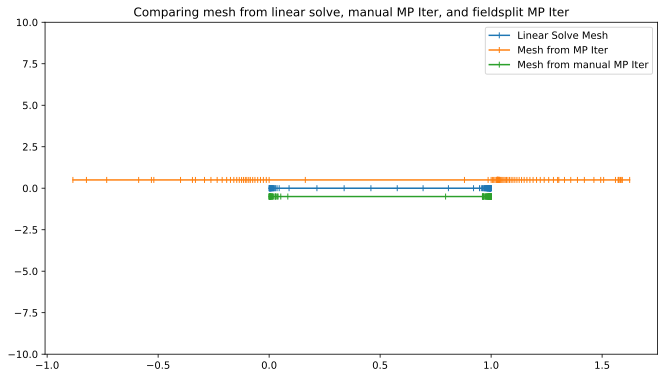

In [ ]:
# Compare to the Linear Solve Mesh

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|", label = "Linear Solve Mesh")
plt.plot(x.dat.data[perm_x], [1/2 for i in range(len(x.dat.data[:]))], marker = "|", label = "Mesh from MP Iter")
plt.plot(x_noMP.dat.data[perm_x], [-1/2 for i in range(len(x_noMP.dat.data[:]))], marker = "|", label = "Mesh from manual MP Iter")
plt.title('Comparing mesh from linear solve, manual MP Iter, and fieldsplit MP Iter')
plt.ylim(-10, 10)
plt.legend()
plt.show()
print()
print()

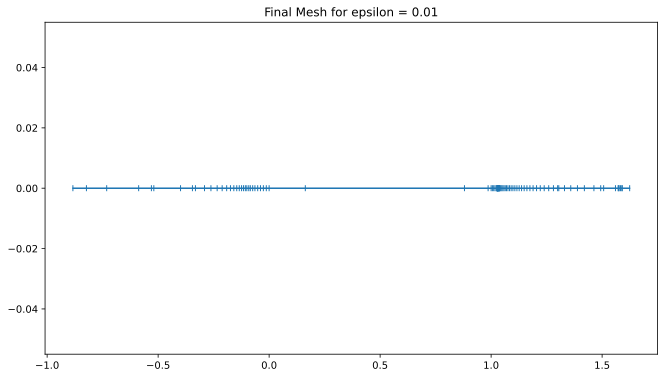

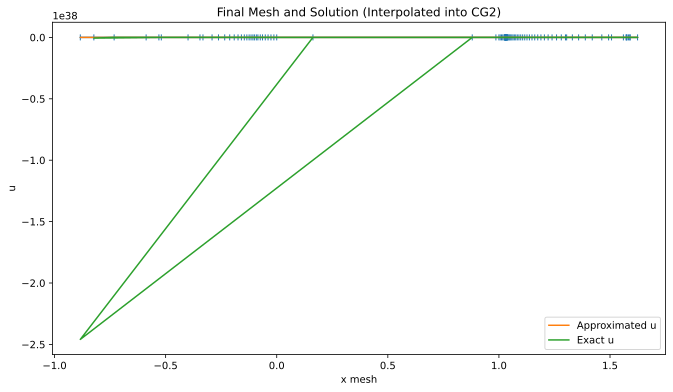

In [ ]:
# Plot the results

# exact u
top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x)/(epsilon**2 - 1)
u_exact = top/bottom - sub



# Print final mesh
plt.plot(x.dat.data[perm_x], [0 for i in range(len(x.dat.data[perm_x]))], marker = "|")
plt.title("Final Mesh for epsilon = " + str(float(epsilon)))
plt.show()
print()
print()



# Solutions and Meshes

print()
plt.plot(x.dat.data[perm_x], np.zeros_like(x.dat.data[perm_x]), marker = "|")
plt.plot(x.dat.data[perm_x], Function(V).interpolate(u).dat.data[perm_x], label = "Approximated u")
plt.plot(x.dat.data[perm_x], Function(V).interpolate(u_exact).dat.data[perm_x], label = "Exact u")
plt.title("Final Mesh and Solution (Interpolated into CG2)")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()

print()
print()

